In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque
import os
%matplotlib inline


# Set device to CUDA if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------
# Replay Buffer Implementation
# ---------------------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards), 
                np.array(next_states), np.array(dones, dtype=np.float32))
    
    def __len__(self):
        return len(self.buffer)

# ---------------------------
# Q-Network (MLP) Definition
# ---------------------------
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        # Two hidden layers with 256 units each.
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, output_dim)
        self.init_weights()
    
    def init_weights(self):
        # Initialize weights uniformly between -0.001 and 0.001.
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, -0.001, 0.001)
                nn.init.uniform_(m.bias, -0.001, 0.001)
                
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

# ---------------------------
# Epsilon-greedy Action Selection
# ---------------------------
def select_action(state, q_network, epsilon, env):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = q_network(state_tensor)
        return q_values.argmax().item()

# ---------------------------
# Single-step Updates (Online)
# ---------------------------
def update_q_learning(q_network, optimizer, state, action, reward, next_state, done, gamma):
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
    q_value = q_network(state_tensor)[0, action]
    
    if done:
        target = torch.FloatTensor([reward]).to(device)
    else:
        with torch.no_grad():
            next_q_values = q_network(next_state_tensor)
        target = torch.FloatTensor([reward + gamma * next_q_values.max().item()]).to(device)
    
    loss = nn.MSELoss()(q_value, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def update_expected_sarsa(q_network, optimizer, state, action, reward, next_state, done, gamma, epsilon, env):
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
    q_value = q_network(state_tensor)[0, action]
    
    if done:
        expected_q = 0.0
    else:
        with torch.no_grad():
            next_q_values = q_network(next_state_tensor)
        num_actions = env.action_space.n
        best_action = next_q_values.argmax().item()
        # epsilon-greedy policy probabilities:
        probs = torch.ones(num_actions).to(device) * (epsilon / num_actions)
        probs[best_action] += (1 - epsilon)
        expected_q = torch.sum(next_q_values * probs)
    
    target = reward + gamma * expected_q
    loss = nn.MSELoss()(q_value, torch.tensor(target, device=device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

# ---------------------------
# Mini-batch Updates (with Replay Buffer)
# ---------------------------
def update_q_learning_replay(q_network, optimizer, batch, gamma):
    states, actions, rewards, next_states, dones = batch
    states      = torch.FloatTensor(states).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    actions     = torch.LongTensor(actions).to(device)
    rewards     = torch.FloatTensor(rewards).to(device)
    dones       = torch.FloatTensor(dones).to(device)
    
    q_values = q_network(states)
    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    with torch.no_grad():
        next_q_values = q_network(next_states)
        next_q_max, _ = next_q_values.max(dim=1)
    targets = rewards + gamma * next_q_max * (1 - dones)
    
    loss = nn.MSELoss()(q_value, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def update_expected_sarsa_replay(q_network, optimizer, batch, gamma, epsilon, env):
    states, actions, rewards, next_states, dones = batch
    states      = torch.FloatTensor(states).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    actions     = torch.LongTensor(actions).to(device)
    rewards     = torch.FloatTensor(rewards).to(device)
    dones       = torch.FloatTensor(dones).to(device)
    
    q_values = q_network(states)
    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    with torch.no_grad():
        next_q_values = q_network(next_states)
    num_actions = env.action_space.n
    best_actions = next_q_values.argmax(dim=1)
    probs = torch.ones(next_q_values.size(), device=device) * (epsilon / num_actions)
    for i in range(probs.size(0)):
        probs[i, best_actions[i]] += (1 - epsilon)
    expected_q = torch.sum(next_q_values * probs, dim=1)
    targets = rewards + gamma * expected_q * (1 - dones)
    
    loss = nn.MSELoss()(q_value, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

# ---------------------------
# Running a Single Episode
# ---------------------------
def run_episode(env, q_network, algorithm, optimizer, gamma, epsilon, replay, replay_buffer, batch_size):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = select_action(state, q_network, epsilon, env)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        
        if replay:
            replay_buffer.push(state, action, reward, next_state, done)
            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                if algorithm == "q_learning":
                    update_q_learning_replay(q_network, optimizer, batch, gamma)
                elif algorithm == "expected_sarsa":
                    update_expected_sarsa_replay(q_network, optimizer, batch, gamma, epsilon, env)
        else:
            if algorithm == "q_learning":
                update_q_learning(q_network, optimizer, state, action, reward, next_state, done, gamma)
            elif algorithm == "expected_sarsa":
                update_expected_sarsa(q_network, optimizer, state, action, reward, next_state, done, gamma, epsilon, env)
                
        state = next_state
    return total_reward

# ---------------------------
# Run a Single Experiment (one seed)
# ---------------------------
import tqdm
def run_experiment(env_name, algorithm, epsilon, learning_rate, replay,
                   num_episodes=1000, seed=0, gamma=0.99, batch_size=32):
    env = gym.make(env_name)
    env.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Determine input and output dimensions.
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    q_network = QNetwork(input_dim, output_dim).to(device)
    optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
    
    replay_buffer = ReplayBuffer(capacity=1000000) if replay else None
    
    episode_rewards = []
    for episode in tqdm.tqdm(range(num_episodes)):
        total_reward = run_episode(env, q_network, algorithm, optimizer, gamma,
                                   epsilon, replay, replay_buffer, batch_size)
        episode_rewards.append(total_reward)
    env.close()
    return episode_rewards

Using device: cuda


Running Acrobot-v1 | Replay: False | Epsilon: 0.1 | LR: 0.25


  0%|          | 0/100 [00:00<?, ?it/s]/home/slsecret/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2310838/1273545936.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = nn.MSELoss()(q_value, torch.tensor(target, device=device))
100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


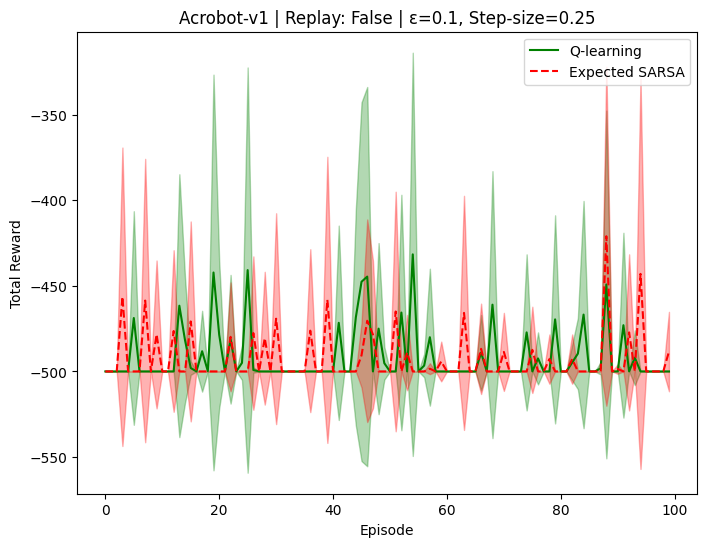

  0%|          | 0/100 [00:00<?, ?it/s]

Saved plot to plots/Acrobot-v1_replay_False_eps_0.1_lr_0.25.png
Running Acrobot-v1 | Replay: False | Epsilon: 0.1 | LR: 0.125


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


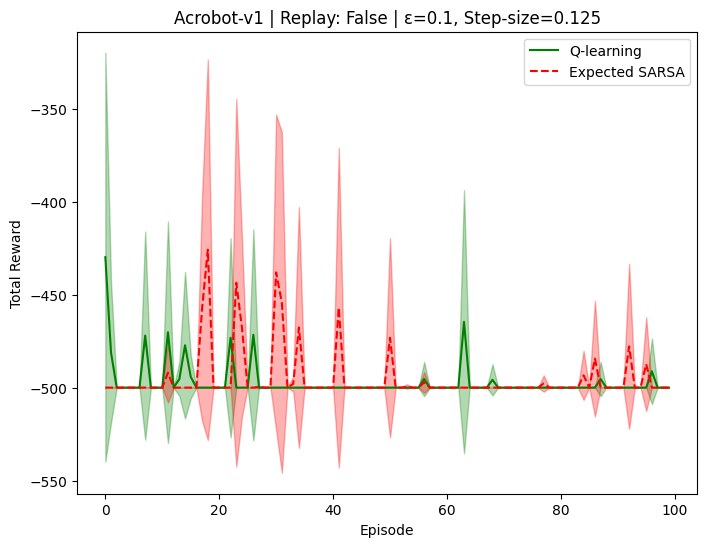

  0%|          | 0/100 [00:00<?, ?it/s]

Saved plot to plots/Acrobot-v1_replay_False_eps_0.1_lr_0.125.png
Running Acrobot-v1 | Replay: False | Epsilon: 0.1 | LR: 0.0625


 13%|█▎        | 13/100 [00:09<01:01,  1.41it/s]


KeyboardInterrupt: 

In [2]:
# Hyperparameter settings (adjust as needed)
epsilons = [0.1, 0.2, 0.3]
learning_rates = [0.25, 0.125, 0.0625]  # step-size parameters
algorithms = ["q_learning", "expected_sarsa"]
replay_settings = [False, True]
# Two environments: Acrobot and Assault-ram.
env_list = ["Acrobot-v1", "ALE/Assault-ram-v52"]

# For demonstration (reduce seeds/episodes for quick testing)
num_seeds = 5     # Use 50 for full experiments.
num_episodes = 100  # Use 1000 for full experiments.

os.makedirs("plots", exist_ok=True)

# Loop over each configuration.
for env_name in env_list:
    for replay in replay_settings:
        for epsilon in epsilons:
            for lr in learning_rates:
                results = {alg: [] for alg in algorithms}
                print(f"Running {env_name} | Replay: {replay} | Epsilon: {epsilon} | LR: {lr}")
                for alg in algorithms:
                    for seed in range(num_seeds):
                        rewards = run_experiment(env_name, alg, epsilon, lr, replay,
                                                    num_episodes=num_episodes, seed=seed)
                        results[alg].append(rewards)
                
                # Aggregate results.
                q_rewards = np.array(results["q_learning"])
                es_rewards = np.array(results["expected_sarsa"])
                episodes = np.arange(num_episodes)
                
                q_mean = np.mean(q_rewards, axis=0)
                q_std  = np.std(q_rewards, axis=0)
                es_mean = np.mean(es_rewards, axis=0)
                es_std  = np.std(es_rewards, axis=0)
                
                plt.figure(figsize=(8,6))
                # Q-learning: green solid line.
                plt.fill_between(episodes, q_mean - q_std, q_mean + q_std, color='green', alpha=0.3)
                plt.plot(episodes, q_mean, color='green', label="Q-learning", linestyle='-')
                
                # Expected SARSA: red dashed line.
                plt.fill_between(episodes, es_mean - es_std, es_mean + es_std, color='red', alpha=0.3)
                plt.plot(episodes, es_mean, color='red', label="Expected SARSA", linestyle='--')
                
                plt.xlabel("Episode")
                plt.ylabel("Total Reward")
                title = f"{env_name} | Replay: {replay} | ε={epsilon}, Step-size={lr}"
                plt.title(title)
                plt.legend()
                
                # Save the plot.
                safe_env_name = env_name.replace("/", "_")
                filename = f"plots/{safe_env_name}_replay_{replay}_eps_{epsilon}_lr_{lr}.png"
                plt.savefig(filename)
                plt.show()
                plt.close()
                print(f"Saved plot to {filename}")